# DTSA 5511 Disater Tweets Kaggle Mini Project

## Project Topic

This project is about building a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t, using a dataset of 10,000 tweets that were hand classified.

In [1]:
##### added line to ensure plots are showing
%matplotlib inline
#####

# Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sea
import warnings
import pickle
import os

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.linear_model import RidgeClassifier

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#try:
#  import ktrain
#except:
#  !pip install ktrain
#  os.kill(os.getpid(), 9)
#from ktrain import text
#from ktrain.text import texts_from_df

In [2]:
# Mounting google drive to store the best models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## The Dataset

This is a public dataset published by Kaggle for the *Disaster Tweets* competition that contains 10,876 Tweets, which are binary labeled.

Files:
- train.csv - 7,613 records in 5 columns
- test.csv - 3,263 records in 4 columns
- sample_submission.csv - 3,263 records in 4 columns

Kaggle source: https://www.kaggle.com/competitions/nlp-getting-started/data  

The dataset was created by the company *figure-eight* and originally shared on their *Data For Everyone* website here.

Original source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

In [3]:
# Loading testing and training data
df_train = pd.read_csv('https://raw.githubusercontent.com/rojasael/DTSA/main/5511/W4_Kaggle_Mini_Project/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/rojasael/DTSA/main/5511/W4_Kaggle_Mini_Project/test.csv')
df_sample = pd.read_csv('https://raw.githubusercontent.com/rojasael/DTSA/main/5511/W4_Kaggle_Mini_Project/sample_submission.csv')

## Exploratory Data Analysis

First, let's inspect, visualize, clean and transform the data in preparation for building and training the prediction models.

### Visualizing the datasets

Display the `train` set:

In [4]:
# print the train set
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Display the `test` set:

In [5]:
# print the test set
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


Display the sample solution set:

In [6]:
# print `sample_submission` set
df_sample

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


### Feature Variables

Let's take a look at the feature variables and target variable within the datasets.

In [7]:
# print information about the train set
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
# print information about the test set
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


From the information, we can observe that some of the variables (i.e., `keyword`, `location`) have got some missing values. This issue is more relevant in the case of the `location` with around **33%** and of the values missing in both sets.

Now, let's a closer look at these two variables, to understand how to handle them.

In [9]:
# print some of the unique values of the 'keyword' variable
df_train['keyword'].value_counts()

keyword
fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [10]:
# print some of the unique values of the 'location' variable
df_train['location'].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
Some pum pum             1
Paulton, England         1
SEA Server               1
todaysbigstock.com       1
???????? ?????????.      1
Name: count, Length: 3341, dtype: int64

Having observed some the values of these two variables, the best way to handle them is dropping them from the datasets.

In the case of `keyword`, the variable might mislead the model to classify wrongly the Tweets, as we don't know the basis on how this keyword was defined, factually or methaphorical.

For the varaible `location`, there is no prediction power in it, as it is not consistent, in some instances it is a country, a city, a street, or even a coordinate.

In [11]:
# drop 'keyword' and 'location' columns
df_train.drop(columns=['keyword', 'location'], inplace=True)
df_test.drop(columns=['keyword', 'location'], inplace=True)

### Duplicated values

Next, let's check for duplicated Tweets within the datasets.

In [12]:
# check for duplicated Tweets in train set
df_train['id'].duplicated().value_counts()

id
False    7613
Name: count, dtype: int64

In [13]:
# check for duplicated Tweets in test set
df_test['id'].duplicated().value_counts()

id
False    3263
Name: count, dtype: int64

### Data Distribution Analysis

Let's get an idea of the distribution of the `target` variable.

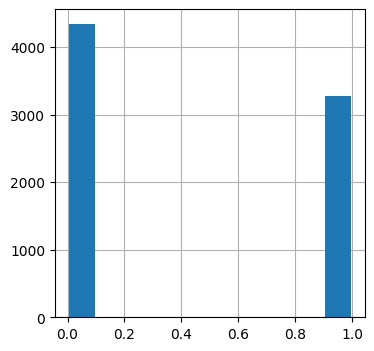

In [14]:
df_train['target'].hist(figsize=(4,4), zorder=2, rwidth=0.9)
plt.show()

From the histogram, we can observe some class imbalace is present our `train` set.

A predictive model trained on imbalance data might be biased towards the majority class. Therefore, we will proceed to apply a random undersampling technique to balance the classes.

In [15]:
# print value count for each class
df_train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

Let's apply a typical random oversampling technique.

In [16]:
# transfering the minority class instances
df_train_bal = df_train[df_train['target']==1]
# number of sample for minority class
sample = df_train_bal.shape[0]

# add a random sample of the majority class
df_train_bal = pd.concat([df_train_bal, df_train[df_train['target']==0].sample(n=sample, replace=False, random_state=42)])

In [17]:
# recheck target variable distribution
df_train_bal['target'].value_counts()

target
1    3271
0    3271
Name: count, dtype: int64

Now we got a balance training set to work with.

### Split Train Set

Before proceeding with transformation, let's split our balanced train set into two sets one for training and another for validation.

In [18]:
# split the 'df_train_bal' into training / validation
df_train_sp, df_val_sp = train_test_split(df_train_bal, test_size=0.1, random_state=42)

In [19]:
# print size of datasets
print(f'Training set: {df_train_sp.shape}')
print(f'Validation set: {df_val_sp.shape}')

Training set: (5887, 3)
Validation set: (655, 3)


### Features Importance

Now, let's process the raw text from the Tweets into feature vectors by using a *Bag of Words* approach. This involves using a Tf-idf-weighted document-term sparse matrix to encode the features, so we can observe which key words are predominat for each class.

Let's set up a function to transform the raw text into word encoding using `TfidfVectorizer`.

In [20]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

# compute size of data
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6

# vectorize the text
def vectorize_dataset(feature, target, train_set, valid_set, test_set, max_df=0.9, min_df=0.1, max_features=None, norm=None,
                      strip_accents='ascii', stop_words='english', lowercase=True, verbose=True):
    """Load and vectorize the dataset."""

    # split target in a training set and a test set
    y_train = train_set[target]
    y_valid = valid_set[target]

    # Setup vectorizer
    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features,
                                 norm=norm, strip_accents=strip_accents, stop_words=stop_words, lowercase=True)

    # Fit vectorizer with all texts from train, valid and test sets
    t0 = time()
    whole_set = pd.concat([train_set[feature], valid_set[feature], test_set[feature]])
    vectorizer.fit(whole_set)
    duration_vctzr = time() - t0

    # Extracting features from the train set using the sparse vectorizer
    t0 = time()
    X_train = vectorizer.transform(train_set[feature])
    duration_train = time() - t0

    # Extracting features from the valid set using the vectorizer
    t0 = time()
    X_valid = vectorizer.transform(valid_set[feature])
    duration_valid = time() - t0

    # Extracting features from the test data using the vectorizer
    t0 = time()
    X_test = vectorizer.transform(test_set[feature])
    duration_test = time() - t0

    # Get vectorized feature names
    feature_names = vectorizer.get_feature_names_out()

    # Print information of the pre-processing
    if verbose:
        # compute size of loaded data
        data_vctzr_size_mb = size_mb(whole_set)
        data_train_size_mb = size_mb(train_set[feature])
        data_valid_size_mb = size_mb(valid_set[feature])
        data_test_size_mb = size_mb(test_set[feature])

        # print size of datasets
        print(f"{len(train_set[feature])} documents - "
              f"{data_train_size_mb:.2f}MB (training set)")

        print(f"{len(valid_set[feature])} documents - "
              f"{data_valid_size_mb:.2f}MB (valid set)")

        print(f"{len(test_set[feature])} documents - "
              f"{data_test_size_mb:.2f}MB (test set)")

        print(f"vectorizer learning done in {duration_vctzr:.3f}s "
              f"at {(data_vctzr_size_mb) / duration_vctzr:.3f}MB/s")

        print(f"vectorize training done in {duration_train:.3f}s "
              f"at {data_train_size_mb / duration_train:.3f}MB/s")
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")

        print(f"vectorize validation done in {duration_valid:.3f}s "
              f"at {data_valid_size_mb / duration_valid:.3f}MB/s")
        print(f"n_samples: {X_valid.shape[0]}, n_features: {X_valid.shape[1]}")

        print(f"vectorize testing done in {duration_test:.3f}s "
              f"at {data_test_size_mb / duration_test:.3f}MB/s")
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_valid, X_test, y_train, y_valid, feature_names

Now, let's transform the feature variable `text` from the training, validation and test sets.

We will start with a wide inclusion of words, `max_df=0.9` and `min_df=1`, as the maximum length of a single tweet used to be just 140 characters.

In [21]:
# vectorize the text data
X_train, X_valid, X_test, y_train, y_valid, feature_names = vectorize_dataset('text', 'target',
    df_train_sp, df_val_sp, df_test, max_df=.9, min_df=0, norm=None,
    strip_accents='unicode', stop_words='english', lowercase=True, verbose=True)

5887 documents - 0.60MB (training set)
655 documents - 0.07MB (valid set)
3263 documents - 0.33MB (test set)
vectorizer learning done in 0.216s at 4.648MB/s
vectorize training done in 0.099s at 6.069MB/s
n_samples: 5887, n_features: 25727
vectorize validation done in 0.012s at 5.586MB/s
n_samples: 655, n_features: 25727
vectorize testing done in 0.055s at 6.050MB/s
n_samples: 3263, n_features: 25727


From the results of the vectorization, we can observe that with a wide inclusion of words resulted in 25,727 features.

Now, let's define a function that will help us to get a better understanding the outcome.

In [22]:
# function to plot top 15 features
def top_words(feature_names, X, y, class_index=[0, 1]):
  df_tfidf = pd.DataFrame(X.toarray(), columns=feature_names)

  # reset y set
  y_reset =  y.reset_index(drop=True)

  # define subplots
  fig, ax = plt.subplots(1,2,figsize=(8,4))

  for i in class_index:
    # search indexes for each class
    idx = list(y_reset[y_reset==i].index)

    # Sort feature names by TF-IDF scores
    tweet = df_tfidf.iloc[idx].mean(axis=0).sort_values(ascending=False)

    # Bar chart
    plt.subplot(1,2,i+1)
    tweet[:15].plot(kind='bar')
    plt.title(f'Class: {i}')
    plt.ylabel('TF-IDF Score')
    plt.xlabel('Features')

  fig.tight_layout(h_pad=20)
  plt.show()

Let's visualize the results from the word encoding by plotting the top fifteen (15) feature names for each class.

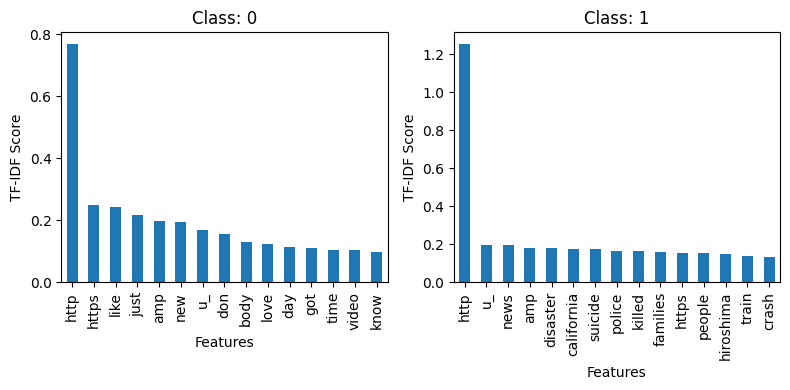

In [23]:
# plot top features for train set
top_words(feature_names, X_train, y_train)

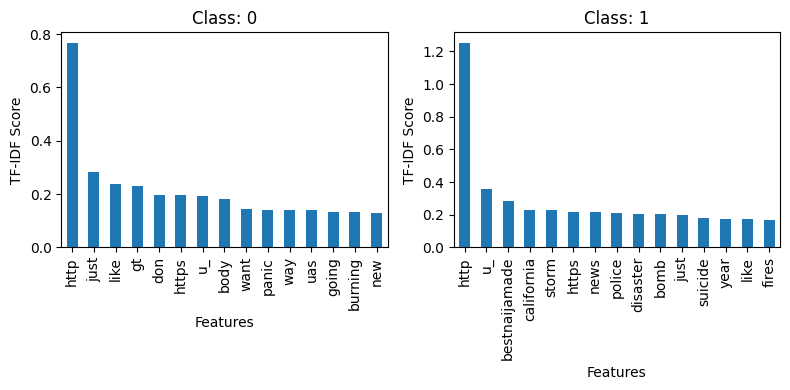

In [24]:
# plot top features for valid set
top_words(feature_names, X_valid, y_valid)

From the plots, we can observe some specific keywords related to disasters are present in the `Class 1` graph, which are not present in `Class 0`. This correlation is a promising initial indicator for classifying Tweets.  

### Data Transformation

For building our models, we will use *Word Embedding* instead of using *TF-IDF*, as it only considers the frequency of the words in the document and the corpus.

*Word Embedding* represents words as vectors in a high-dimensional space, which capture the semantic meaning of words.

In [25]:
# convert to tf datasets
ar_train = (df_train_sp['text'].values, df_train_sp['target'].values)
ar_valid = (df_val_sp['text'].values, df_val_sp['target'].values)
ar_test = (df_test['text'].values)

# tf datasets
tf_train = tf.data.Dataset.from_tensor_slices((df_train_sp['text'].values,df_train_sp['target'].values))
tf_valid = tf.data.Dataset.from_tensor_slices((df_val_sp['text'].values,df_val_sp['target'].values))
tf_test = tf.data.Dataset.from_tensor_slices(df_test['text'].values)

# split the train and valid data into batches of 32, and shuffle the training set
batch_size = 32
tf_train = tf_train.shuffle(buffer_size=len(tf_train), seed=42)
tf_train = tf_train.batch(batch_size)
tf_valid = tf_valid.batch(batch_size)
tf_test = tf_test.batch(batch_size)

# print one example for the tf train set
example, label = next(iter(tf_train))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b'FedEx no longer will ship potential bioterror pathogens - Atlanta Business Chronicle http://t.co/YLLQJljiIQ'

Label:  0


In [26]:
# Determine number of batches per set
tf_train_batch = len(tf_train)
tf_valid_batch = len(tf_valid)
tf_test_batch = len(tf_test)

print('Number of batches')
print('train / validation / test')
print(tf_train_batch, '/', tf_valid_batch, '/', tf_test_batch)

Number of batches
train / validation / test
184 / 21 / 102


In [27]:
# set length of the encoder output vector
max_length = 25

# set TextVectorization layer to normalize, split, and map strings to integers
encoder = TextVectorization(max_tokens=50000,
                            standardize='lower_and_strip_punctuation',
                            split='whitespace',
                            output_mode='int',
                            output_sequence_length=25,
                            )

# adapt the TextVectorization layer to the training data.
encoder.adapt(tf_train.map(lambda text, _: text))

# calculate vocabulary size
vocab_size = len(encoder.get_vocabulary())

Let's test the encoder layer with the example from train set.

In [28]:
# extracting the vocabulary from the TextVectorization layer
vocabulary = np.array(encoder.get_vocabulary())

# encoding a test example and decoding it back
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b'FedEx no longer will ship potential bioterror pathogens - Atlanta Business Chronicle http://t.co/YLLQJljiIQ'
encoded:  [  485    40   569    42   912  1461   519  1346  3671   546  5401 11298
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
decoded:  fedex no longer will ship potential bioterror pathogens atlanta business chronicle httptcoyllqjljiiq             


## Model Building and Training

For modeling, we will test different RNN architectures to evaluate which one performs best. This involves:

* An embedding layer to convert each word into a fixed length vector of defined size.
* Two (2) RNN layers to handle the sequence of words, where the output from the previous step is fed as input to the current step.

* A classifier section with a basic layout of 3x`Dense` layers with `Dropout` regularization.

The `Dropout` regularization will ensure the model doesn't overfit so quickly.

To find the best model, we will set up learning rate schedule with exponential decay, a checkpoint to save the best model based on validation loss, and an early stopping mechanism to save time once the model start overfitting the training data.

### Visualize the Convergence

Before proceeding with the training, let's set a function that will allow us to visualize how the metrics (i.e., loss function) converge during the training process.

In [29]:
# Plot metrics vs epoch
def history_plot(model):
    # initiate dict
    hist_dict = {}
    # iterate across each metric
    for metric in model.history.keys():
        # extract metric values
        hist_dict[metric] = model.history[metric]

    # range of epoch
    epoch_range = range(1, len(hist_dict['loss'])+1)
    # set plot size
    plt.figure(figsize=[14,4])
    # number of sub-plots
    n = int(len(hist_dict.keys())/2)

    # iterate across number of sub-plots
    for i in range(n):
        # metric
        metric = list(hist_dict.keys())[i]
        # plot metric values
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, hist_dict[metric], label='Training')
        plt.plot(epoch_range, hist_dict['val_' + metric], label='Validation')
        plt.xlabel('epoch'); plt.ylabel(metric); plt.title(f'Convergence of {metric}')
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

### SimpleRNN Architecture

We will begin with a basic `SimpleRNN` architecture.

In [30]:
# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# set model architecture
mdl_SRNN = Sequential([
            encoder,
            Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length, mask_zero=True),
            SimpleRNN(units=64, activation='relu',  return_sequences=True),
            SimpleRNN(units=64, activation='relu'),
            Dropout(0.3),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
            ])

# Summary of the model
mdl_SRNN.summary()

# learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4,
            decay_steps=tf_train_batch,
            decay_rate=0.85,
            staircase=True)

# Compile the model
mdl_SRNN.compile(
            loss=keras.losses.BinaryCrossentropy(from_logits=False),
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=['accuracy', AUC()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 25)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 25, 64)            1213440   
                                                                 
 simple_rnn (SimpleRNN)      (None, 25, 64)            8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                        

In [31]:
%%time
## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                              filepath = '/content/drive/MyDrive/mdl_SRNN_weights_best.keras',
                              verbose = 1,
                              save_best_only=True
                              )

# Set an early stopper
stopper = keras.callbacks.EarlyStopping(
                                      monitor="val_accuracy",
                                      min_delta=0,
                                      patience=0,
                                      verbose=0,
                                      mode="auto",
                                      baseline=None,
                                      restore_best_weights=False,
                                      start_from_epoch=10,
                                      )

# Training the model
hist_SRNN = mdl_SRNN.fit(
                        tf_train,
                        steps_per_epoch = tf_train_batch,
                        epochs = 30,
                        validation_data = tf_valid,
                        validation_steps = tf_valid_batch,
                        verbose = 1,
                        callbacks=[checkpointer, stopper]
                        )

# calculate wall time
dur_SRNN = time() - t0

Epoch 1/30
184/184 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.4958 - auc: 0.4890
Epoch 1: val_loss improved from inf to 0.69263, saving model to /content/drive/MyDrive/mdl_SRNN_weights_best.keras
184/184 [==============================] - 33s 143ms/step - loss: 0.6939 - accuracy: 0.4958 - auc: 0.4890 - val_loss: 0.6926 - val_accuracy: 0.5374 - val_auc: 0.5475
Epoch 2/30
184/184 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5076 - auc: 0.5152
Epoch 2: val_loss improved from 0.69263 to 0.69229, saving model to /content/drive/MyDrive/mdl_SRNN_weights_best.keras
184/184 [==============================] - 14s 77ms/step - loss: 0.6928 - accuracy: 0.5076 - auc: 0.5152 - val_loss: 0.6923 - val_accuracy: 0.5344 - val_auc: 0.5575
Epoch 3/30
184/184 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5342 - auc: 0.5498
Epoch 3: val_loss improved from 0.69229 to 0.69162, saving model to /content/drive/MyDrive/mdl_SRNN_weigh

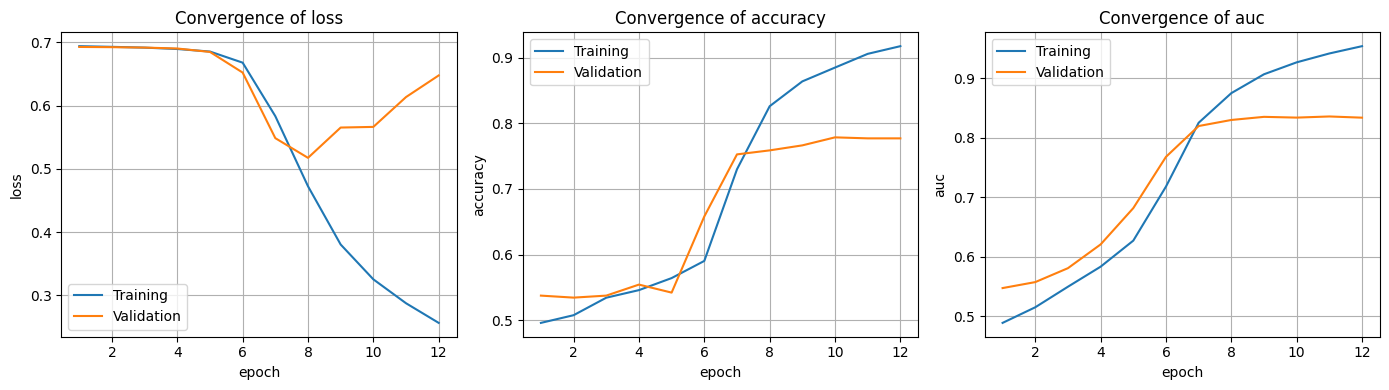

In [32]:
# monitor training convergence
history_plot(hist_SRNN)

 The best model was found at the 8th epoch with a validation accuracy of 75.88% and a validation AUC of 82.9%.

 The rapid increase in the validation loss after the 8th epoch suggests that the model is overfitting the training data.

 It took just 2min 42s to train, and stopped early at 12 epochs.

### LSTM Architecture

Next, we will replace the `SimpleRNN` layers by `LSTM` layers in the architecture.

In [33]:
# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# set model architecture
mdl_LSTM = Sequential([
            encoder,
            Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length, mask_zero=True),
            LSTM(64, activation='relu', return_sequences=True),
            LSTM(64, activation='relu'),
            Dropout(0.3),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
            ])

# Summary of the model
mdl_LSTM.summary()

# learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4,
            decay_steps=tf_train_batch,
            decay_rate=0.85,
            staircase=True)

# Compile the model
mdl_LSTM.compile(
            loss=keras.losses.BinaryCrossentropy(from_logits=False),
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=['accuracy', AUC()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 25)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 25, 64)            1213440   
                                                                 
 lstm (LSTM)                 (None, 25, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                      

In [34]:
%%time
## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                              filepath = '/content/drive/MyDrive/mdl_LSTM_weights_best.keras',
                              verbose = 1,
                              save_best_only=True
                              )

# Set an early stopper
stopper = keras.callbacks.EarlyStopping(
                                      monitor="val_accuracy",
                                      min_delta=0,
                                      patience=0,
                                      verbose=0,
                                      mode="auto",
                                      baseline=None,
                                      restore_best_weights=False,
                                      start_from_epoch=10,
                                      )

# Training the model
hist_LSTM = mdl_LSTM.fit(
                        tf_train,
                        steps_per_epoch = tf_train_batch,
                        epochs = 30,
                        validation_data = tf_valid,
                        validation_steps = tf_valid_batch,
                        verbose = 1,
                        callbacks=[checkpointer, stopper]
                        )

# calculate wall time
dur_LSTM = time() - t0

Epoch 1/30
184/184 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4974 - auc_1: 0.4982
Epoch 1: val_loss improved from inf to 0.69308, saving model to /content/drive/MyDrive/mdl_LSTM_weights_best.keras
184/184 [==============================] - 31s 141ms/step - loss: 0.6932 - accuracy: 0.4974 - auc_1: 0.4982 - val_loss: 0.6931 - val_accuracy: 0.4840 - val_auc_1: 0.5000
Epoch 2/30
184/184 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5409 - auc_1: 0.5382
Epoch 2: val_loss improved from 0.69308 to 0.69182, saving model to /content/drive/MyDrive/mdl_LSTM_weights_best.keras
184/184 [==============================] - 17s 94ms/step - loss: 0.6927 - accuracy: 0.5409 - auc_1: 0.5382 - val_loss: 0.6918 - val_accuracy: 0.5008 - val_auc_1: 0.6496
Epoch 3/30
184/184 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.6931 - auc_1: 0.7562
Epoch 3: val_loss improved from 0.69182 to 0.60669, saving model to /content/drive/MyDrive/

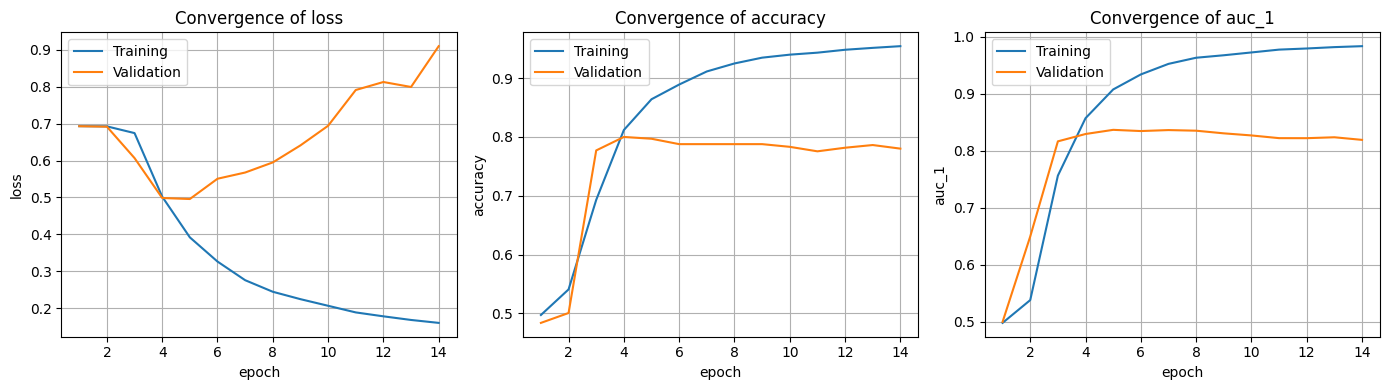

In [35]:
# monitor training convergence
history_plot(hist_LSTM)

  The best model was found at the 4th epoch with a validation accuracy of 79.69% and a validation AUC of 83.65%.

 The rapid increase in the validation loss after the 4th epoch suggests that the model is overfitting the training data.

 It took just 3min 58s to train, and stopped early at 12 epochs.

### GRU Architecture

Now, we will try with `GRU` layers.

In [36]:
# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# set model architecture
mdl_GRU = Sequential([
                    encoder,
                    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length, mask_zero=True),
                    GRU(64, activation='relu', return_sequences=True),
                    GRU(64, activation='relu'),
                    Dropout(0.3),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(64, activation='relu'),
                    Dropout(0.5),
                    Dense(1, activation='sigmoid')
                    ])

# learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4,
            decay_steps=tf_train_batch,
            decay_rate=0.85,
            staircase=True)

# Summary of the model
mdl_GRU.summary()

# Compile the model
mdl_GRU.compile(
            loss=keras.losses.BinaryCrossentropy(from_logits=False),
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
            metrics=['accuracy', AUC()])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 25)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 25, 64)            1213440   
                                                                 
 gru (GRU)                   (None, 25, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                      

In [37]:
%%time
## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                              filepath = '/content/drive/MyDrive/mdl_GRU_weights_best.keras',
                              verbose = 1,
                              save_best_only=True
                              )

# Set an early stopper
stopper = keras.callbacks.EarlyStopping(
                                      monitor="val_accuracy",
                                      min_delta=0,
                                      patience=0,
                                      verbose=0,
                                      mode="auto",
                                      baseline=None,
                                      restore_best_weights=False,
                                      start_from_epoch=10,
                                      )

# Training the model
hist_GRU = mdl_GRU.fit(
                      tf_train,
                      steps_per_epoch = tf_train_batch,
                      epochs = 30,
                      validation_data = tf_valid,
                      validation_steps = tf_valid_batch,
                      verbose = 1,
                      callbacks=[checkpointer, stopper]
                      )

# calculate wall time
dur_GRU = time() - t0

Epoch 1/30
184/184 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5094 - auc_2: 0.5180
Epoch 1: val_loss improved from inf to 0.69228, saving model to /content/drive/MyDrive/mdl_GRU_weights_best.keras
184/184 [==============================] - 30s 140ms/step - loss: 0.6930 - accuracy: 0.5094 - auc_2: 0.5180 - val_loss: 0.6923 - val_accuracy: 0.5176 - val_auc_2: 0.5847
Epoch 2/30
184/184 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.5196 - auc_2: 0.5944
Epoch 2: val_loss improved from 0.69228 to 0.68876, saving model to /content/drive/MyDrive/mdl_GRU_weights_best.keras
184/184 [==============================] - 18s 96ms/step - loss: 0.6915 - accuracy: 0.5196 - auc_2: 0.5944 - val_loss: 0.6888 - val_accuracy: 0.6977 - val_auc_2: 0.7395
Epoch 3/30
184/184 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.6703 - auc_2: 0.7517
Epoch 3: val_loss improved from 0.68876 to 0.63113, saving model to /content/drive/MyDrive/md

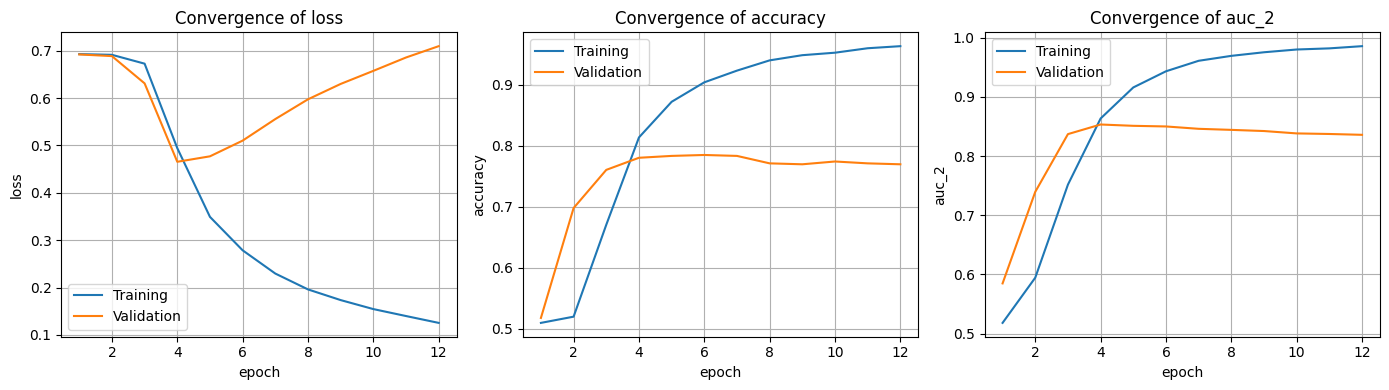

In [38]:
# monitor training convergence
history_plot(hist_GRU)

 The best model was found at the 4th epoch with a validation accuracy of 78.02% and a validation AUC of 85.33%.

The rapid increase in the validation loss after the 4th epoch suggests that the model is overfitting the training data.

It took just 3min 32s to train, and stopped early at 12 epochs.

### Bidirectional Architecture

Finally, we will apply a more complex approach with `Bidirectional` layers and `LSTM` layers.

In [39]:
# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# set model architecture
mdl_BLSTM = Sequential([
            encoder,
            Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length, mask_zero=True),
            Bidirectional(LSTM(64,  return_sequences=True)),
            Bidirectional(LSTM(64)),
            Dropout(0.3),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
            ])

# Summary of the model
mdl_BLSTM.summary()

# Set an early stopper
stopper = keras.callbacks.EarlyStopping(
                                      monitor="val_accuracy",
                                      min_delta=0,
                                      patience=0,
                                      verbose=0,
                                      mode="auto",
                                      baseline=None,
                                      restore_best_weights=False,
                                      start_from_epoch=10,
                                      )
# Compile the model
mdl_BLSTM.compile(
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['accuracy', AUC()])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 25)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 25, 64)            1213440   
                                                                 
 bidirectional (Bidirection  (None, 25, 128)           66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                      

In [40]:
%%time
## capture start time
t0 = time()

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                              filepath = '/content/drive/MyDrive/mdl_BLSTM_weights_best.keras',
                              verbose = 1,
                              save_best_only=True
                              )

# Set an early stopper
stopper = keras.callbacks.EarlyStopping(
                                      monitor="val_accuracy",
                                      min_delta=0,
                                      patience=0,
                                      verbose=0,
                                      mode="auto",
                                      baseline=None,
                                      restore_best_weights=False,
                                      start_from_epoch=10,
                                      )

# Training the model
hist_BLSTM = mdl_BLSTM.fit(
                      tf_train,
                      steps_per_epoch = tf_train_batch,
                      epochs = 30,
                      validation_data = tf_valid,
                      validation_steps = tf_valid_batch,
                      verbose = 1,
                      callbacks=[checkpointer, stopper]
                      )

# calculate wall time
dur_BLSTM = time() - t0

Epoch 1/30
182/184 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5312 - auc_3: 0.5673
Epoch 1: val_loss improved from inf to 0.68374, saving model to /content/drive/MyDrive/mdl_BLSTM_weights_best.keras
184/184 [==============================] - 33s 95ms/step - loss: 0.6918 - accuracy: 0.5318 - auc_3: 0.5680 - val_loss: 0.6837 - val_accuracy: 0.6687 - val_auc_3: 0.7810
Epoch 2/30
183/184 [============================>.] - ETA: 0s - loss: 0.5905 - accuracy: 0.7225 - auc_3: 0.7827
Epoch 2: val_loss improved from 0.68374 to 0.49887, saving model to /content/drive/MyDrive/mdl_BLSTM_weights_best.keras
184/184 [==============================] - 5s 26ms/step - loss: 0.5899 - accuracy: 0.7226 - auc_3: 0.7827 - val_loss: 0.4989 - val_accuracy: 0.7557 - val_auc_3: 0.8262
Epoch 3/30
184/184 [==============================] - ETA: 0s - loss: 0.4239 - accuracy: 0.8342 - auc_3: 0.8822
Epoch 3: val_loss improved from 0.49887 to 0.49548, saving model to /content/drive/MyDrive/

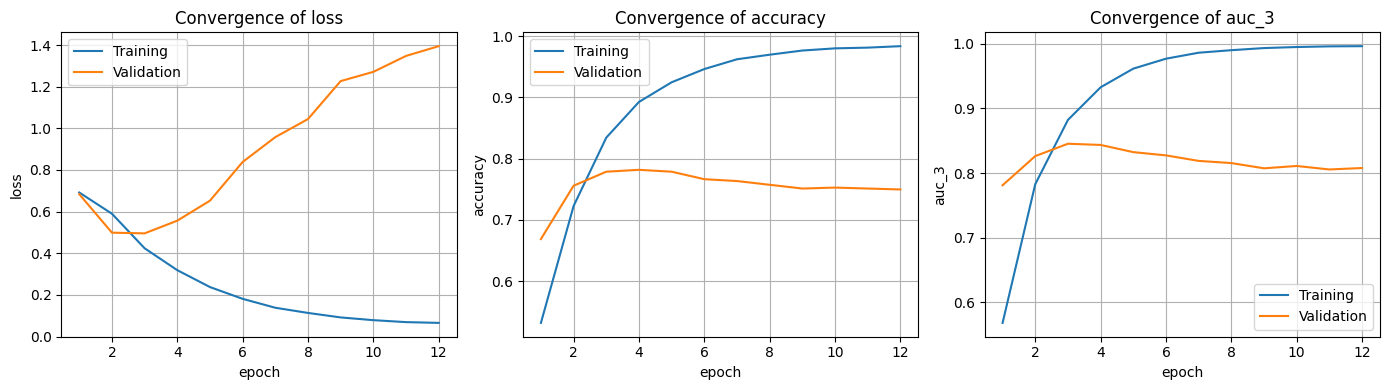

In [41]:
# monitor training convergence
history_plot(hist_BLSTM)

The best model was found at the 3rd epoch with a validation accuracy of 77.86% and a validation AUC of 84.53%.

The rapid increase in the validation loss after the 3th epoch suggests that the model is overfitting the training data.

It took just 1min 14s to train, and stopped early at 12 epochs.

## Results & Analysis

In this section, we will summarize the results, and compare the predictive performance of the models.

### Compare Models Performance

Let's evaluate and compare the predictive performance of the models against the validation set.

In [42]:
# Load the best models
bst_mdl_SRNN = tf.keras.models.load_model('/content/drive/MyDrive/mdl_SRNN_weights_best.keras')
bst_mdl_LSTM = tf.keras.models.load_model('/content/drive/MyDrive/mdl_LSTM_weights_best.keras')
bst_mdl_GRU = tf.keras.models.load_model('/content/drive/MyDrive/mdl_GRU_weights_best.keras')
bst_mdl_BLSTM = tf.keras.models.load_model('/content/drive/MyDrive/mdl_BLSTM_weights_best.keras')

In [43]:
# get scores from validation set
score_SRNN = bst_mdl_SRNN.evaluate(tf_valid)
score_LSTM = bst_mdl_LSTM.evaluate(tf_valid)
score_GRU = bst_mdl_GRU.evaluate(tf_valid)
score_BLSTM = bst_mdl_BLSTM.evaluate(tf_valid)

21/21 [==============================] - 8s 7ms/step - loss: 0.4955 - accuracy: 0.7786 - auc_3: 0.8453


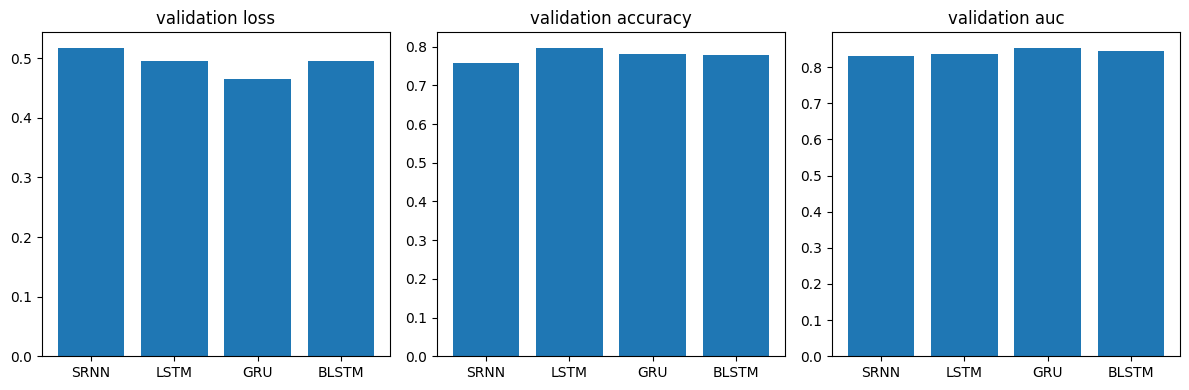

In [44]:
# plot the metrics
## list of model description
mdl_list = ['SRNN', 'LSTM', 'GRU', 'BLSTM']
## metric list
metric_list = ['validation loss', 'validation accuracy', 'validation auc']

## set plot size
plt.figure(figsize=[12,4])
for i in range(len(metric_list)):
  ### plot metric values
  plt.subplot(1,3,i+1)
  names = mdl_list
  values = [score_SRNN[i], score_LSTM[i], score_GRU[i], score_BLSTM[i]]
  plt.bar(range(len(mdl_list)), values, tick_label=names)
  plt.title(metric_list[i])

plt.tight_layout()
plt.show()

From the graphs, we can observe that the best architecture is the one based on `LSTM` layers, having achieved the highest `validation accuracy` at 79.69%.

However, the architecture based on `GRU` layers achieved the lowest validation loss, and the `highest validation auc`.

Finally, the worst performing architecture was the one based on `SRNN` layers,  as it achieved the highest `validation loss`, the lowest `validation accuracy`, and the lowest `validation auc`.

### Training Time Comparison

Let's now take a look at the duration taken to train the models.

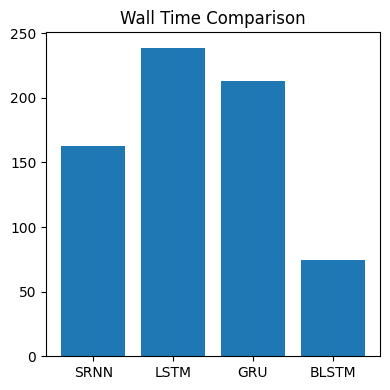

In [45]:
# Time in seconds for each model training
## set plot size
plt.figure(figsize=[4,4])
names = mdl_list
values = [dur_SRNN, dur_LSTM, dur_GRU, dur_BLSTM]
plt.bar(range(len(mdl_list)), values, tick_label=names)
plt.title('Wall Time Comparison')

plt.tight_layout()
plt.show()

Under the same training conditions, the quickest model architecture to train was the `BLSTM` with two bidirectional `LSTM` layers.

The `LSTM` model architecture was the slowest one to train, taking almost 4 mins.

For the small difference in performance, the `BLSTM` model is more computer efficient that the other models.

### Confusion Matrix Comparison

To further evaluate the quality of the prediction, let's generate a confusion matrix for each model, and compare them.

In [46]:
# predict each model class probabilities
y_prob_SRNN = bst_mdl_SRNN.predict(tf_valid)
y_prob_LSTM = bst_mdl_LSTM.predict(tf_valid)
y_prob_GRU = bst_mdl_GRU.predict(tf_valid)
y_prob_BLSTM = bst_mdl_BLSTM.predict(tf_valid)

21/21 [==============================] - 5s 6ms/step


In [47]:
y_pred_SRNN = np.where(y_prob_SRNN > 0.5, 1, 0)
y_pred_LSTM = np.where(y_prob_LSTM > 0.5, 1, 0)
y_pred_GRU = np.where(y_prob_GRU > 0.5, 1, 0)
y_pred_BLSTM = np.where(y_prob_BLSTM > 0.5, 1, 0)

y_pred_list = [y_pred_SRNN, y_pred_LSTM, y_pred_GRU, y_pred_BLSTM]
y_true = df_val_sp['target']

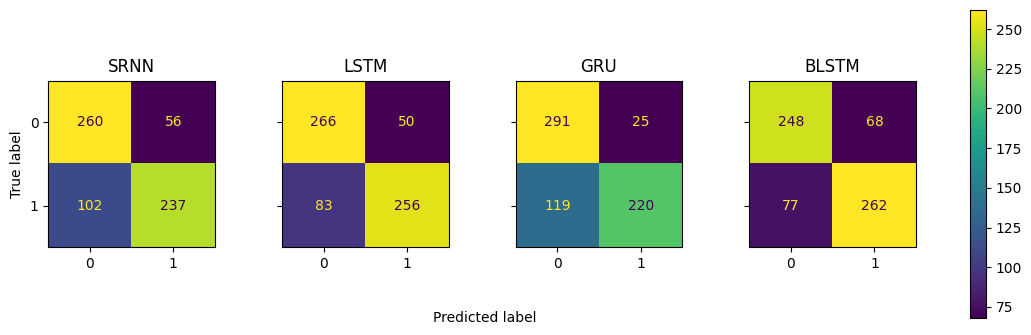

In [48]:
f, axes = plt.subplots(1, 4, figsize=(14, 4), sharey='row')

for i, y_pred in enumerate(y_pred_list):
  cf_matrix = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(cf_matrix)
  disp.plot(ax=axes[i])
  disp.ax_.set_title(mdl_list[i])
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  if i!=0:
      disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

The confusion matrices reiterates the previous observed results, where the `LSTM` model is the most accurate of the model by a small margin.

Moreover, we observe that all the models struggle more with false-positive than false-negative. However, for a disaster warning system, a false positive (false alarm) might be inconvenient but a false negative (missing a real disaster) is much worse.

The `BLSTM` model has got the most balance results.

### Prepare Submission File for Kaggle

In this section, we will evaluate the `test` set using the `LSTM` model, and prepare the submission file for the Kaggle competition.

In [49]:
# prediction of label probability
y_prob_test_LSTM = bst_mdl_LSTM.predict(tf_test)
# input predicted values
y_pred_test_LSTM = np.where(y_prob_test_LSTM > 0.5, 1, 0)

102/102 [==============================] - 2s 12ms/step


In [50]:
# display one end result
df_test_target = pd.DataFrame(y_pred_test_LSTM, columns=['target'])
df_submission = pd.concat([df_sample.drop('target', axis=1), df_test_target], axis=1)
df_submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1


In [51]:
# generate the submission outfile
df_submission.to_csv('/content/drive/MyDrive/fs_RNN.csv', header=True, index=False)

### Kaggle Scores and Leaderboard

Below the score achieved by the `LSTM` model after submitting the results into Kaggle:

![alt text](https://github.com/rojasael/DTSA/blob/main/5511/W4_Kaggle_Mini_Project/DTSA-5511_W4_Disasters_Tweets_Kaggle_Mini_Project%20-%20Kaggle%20Leaderboard.png?raw=1)

The score was placed in the 572th position of the Leaderboard at the time of the submission.

## Conclusions

In this project, we explored the capability of building a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t, using different Recurrent Neural Network achitectures. This involved the testing of four (4) types of RNN layers:

* SRNN - Simple RNN,
* LSTM - Long Short-Term Memory
* GRU - Gated Recurrent Unit
* BiNN - Bidirectional

During the exploration and data anlysis, we removed two feature variables (i.e., `location`, `keyword`) without predictive power from the dataset. Additionally, the train data exhibited an uneven class distribution, which could bias the model towards the majority class. To address this, we applied random undersampling to even the class distribution.

Furthermore, we applied the statistical technic *Term Frequency-Inverse Document Frequency (Tfidf)* to evaluate top words against each specific class. This allowed us to realize that there were some distintive words (i.e., news, disaster, police, crash, suicide, etc.) for the disaster category.  

As a result of the training process, we observed that model training converged quickly in few epochs and then it began to overfit the training data, with the model `LSTM` achieving the highest `validation accuracy` at 79.69%. However, the models `GRU` and `BLSTM` were closeby. The worst model was `SRNN` with an accuracy of 75.88%.

The models struggled more with false positives than false negatives. This translates to mistakenly raising a false alarm but less prompt to miss real disasters.

Finally, we employed the LSTM model to classify Tweets from the test set and submitted the results to Kaggle. The model achieved a score of 0.78179, placing us at position 572 on the leaderboard.

While the results showcase the potential of RNNs, there's room for further optimization. With more time, we could explore hyperparameter tuning, including increasing training epochs, experimenting with optimizers beyond Adam, and evaluating different learning rates, and training/validation ratios.